### Feature Classifier 2022-03
The point of this file is to see how well a model can classify road segments given limited, proximal information from the cities centreline data.
Some of this data is already used for the classification of LTS; however, this model tries to use limited, easy to access datasets that may be transferrable across all cities in order to speed up the classification process without using all of the features used in the 2016 paper.

In [12]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

Import train centreline data

In [95]:
train_path = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centrelinebike_train_spatial.csv'
#'C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centreline_train_spatial.csv'
train_data = pd.read_csv(train_path)
print(train_data.shape)
train_data.head()

(47685, 24)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,INFRA_HIGHORDER,bikelane,AREA_ID
0,1079,1080,20232571,19042,Lobo Mews,20232572,20232553,0,25.816388,20232571,...,201600.0,Other,Mews,Lobo Mews,LINESTRING (618898.5346417543 4832793.03467004...,2,1,NaN,0,2480079.0
1,18899,18900,20111543,14225,Ln N Eglinton W Marlee,20061797,20111546,0,57.456020,20111543,...,201700.0,Laneway,NaN,Ln N Eglinton W Marlee,LINESTRING (625740.8751943215 4839560.42273792...,2,1,NaN,0,2480152.0
2,34456,34457,10494313,3047,Bracken Ave,13461762,13461734,0,74.322093,10494313,...,201500.0,Local,Ave,Bracken Ave,LINESTRING (638317.044654151 4837591.692968905...,1,1,NaN,0,101.0
3,28348,28349,20040607,9763,Byng Ave,13446544,20040609,0,52.472274,20040607,...,201500.0,Local,Ave,Byng Ave,LINESTRING (627572.3315081061 4848280.28118224...,2,1,NaN,0,2480065.0
4,37179,37180,112528,8893,Scarboro Cres,13457118,13457050,0,66.693486,112528,...,201500.0,Local,Cres,Scarboro Cres,LINESTRING (641481.3435743829 4840512.87231042...,1,1,NaN,0,2480085.0


#### Clean and feature engineer using model_functions.py

After evaluating the features in the model, many of them are similar. Ex. Arterial vs. Arterial Ramp. <br>
Before doing any other feature eng, create a function that combines these similar features. Convert to the majoy road types: <br>
Local, Collector, Arterial, Highway. Keep paths seperate. Do we lose info when we do this?

In [96]:
train_data['FEATURE_CODE_DESC'].unique()
def map_centreline_features(data):
    """
    Maps the centreline feature codes to their more like features.
    """
    data_m = data.copy()
    data_m['FEATURE_CODE_DESC'] = data_m['FEATURE_CODE_DESC'].replace({'Laneway':'Local',
                                                                       'Minor Arterial':'Arterial',
                                                                       'Major Arterial':'Arterial',
                                                                       'Major Arterial Ramp':'Arterial',
                                                                       'Walkway':'Trail',
                                                                       'Collector Ramp':'Collector',
                                                                       'Minor Arterial Ramp':'Arterial',
                                                                        })
    
    
    return data_m

train_data = map_centreline_features(train_data)
train_data['FEATURE_CODE_DESC']

0            Other
1            Local
2            Local
3            Local
4            Local
           ...    
47680        Trail
47681    Collector
47682        Trail
47683        Local
47684        Local
Name: FEATURE_CODE_DESC, Length: 47685, dtype: object

In [97]:
# Split features/target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [98]:
# Engineer features usign model functions.
keep_rows = ['FEATURE_CODE_DESC','geometry', 'AREA_ID', 'bikelane']
#X_train['LINEAR_NAME_TYPE'] = X_train['LINEAR_NAME_TYPE'].fillna('')
X_train = droprows(X_train, keep_rows)
X_train = add_regions(X_train, 2, 3)
X_train = dummy(X_train, dummy_feats=['FEATURE_CODE_DESC','x_region','y_region'])
X_train.head()

Principal component 0
explains 74.43585706060858 % of the variance in "lon" and "lat".
Principal component 1
explains 25.564142939391427 % of the variance in "lon" and "lat".


,geometry,AREA_ID,bikelane,FEATURE_CODE_DESC_Arterial,FEATURE_CODE_DESC_Busway,FEATURE_CODE_DESC_Collector,FEATURE_CODE_DESC_Expressway Ramp,FEATURE_CODE_DESC_Local,FEATURE_CODE_DESC_Other,FEATURE_CODE_DESC_Other Ramp,FEATURE_CODE_DESC_Pending,FEATURE_CODE_DESC_Trail,x_region_2,x_region_3,y_region_2,y_region_3
0,"LINESTRING (618898.535 4832793.035, 618890.613...",2480079.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,"LINESTRING (625740.875 4839560.423, 625686.090...",2480152.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
2,"LINESTRING (638317.045 4837591.693, 638388.267...",101.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,"LINESTRING (627572.332 4848280.281, 627622.268...",2480065.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
4,"LINESTRING (641481.343 4840512.872, 641461.165...",2480085.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [99]:
X_train.shape

(47685, 16)

#### Feature Selection
Preprocessing and Cross Validation to choose the best features for the model

Define some models that we would like to test

In [100]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier()

Use the normal feature selector function to see CV results without spatial autocorrolation

In [101]:
feature_selector(model_log, splits=10, X=X_train.iloc[:,2:], y=y_train_access, i=8)

Selected features: ['bikelane', 'FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Trail', 'x_region_3', 'y_region_3']
Selected features: ['bikelane', 'FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Trail', 'x_region_3', 'y_region_3']
Selected features: ['bikelane', 'FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Trail', 'x_region_3', 'y_region_3']
Selected features: ['bikelane', 'FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Trail', 'x_region_3', 'y_region_3']
Selected features: ['bikelane', 'FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Trail', 'x_region_3', 'y_r

<br>Use the spatial cross validation function to get a better look at the feature performance

In [102]:
features = ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Trail',
            'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3', 
            'bikelane',
            #'LINEAR_NAME_TYPE_Ave', 'LINEAR_NAME_TYPE_Cres', 'LINEAR_NAME_TYPE_Ramp', 'LINEAR_NAME_TYPE_Rd', 'LINEAR_NAME_TYPE_St',
           ]

features

['FEATURE_CODE_DESC_Arterial',
 'FEATURE_CODE_DESC_Collector',
 'FEATURE_CODE_DESC_Local',
 'FEATURE_CODE_DESC_Trail',
 'x_region_2',
 'x_region_3',
 'y_region_2',
 'y_region_3',
 'bikelane']

In [85]:
spatial_cv(model_log, grouper=X_train['AREA_ID'], splits=141, X=X_train[features], y=y_train_access)

Mean fold weighted F1 Score: 0.922466394452404
Mean fold accuracy Score: 0.9238414103445979
Mean fold MSE: 0.07615858965540204


In [40]:
spatial_cv(model_rf, grouper=X_train['AREA_ID'], splits=141, X=X_train[features], y=y_train_access)

Mean fold weighted F1 Score: 0.9311810718178549
Mean fold accuracy Score: 0.9298034436644309
Mean fold MSE: 0.07019655633556902


Finally, select Features to be used in hyper parameter tuning

#### Tune hyperparameters
Use random search, and try using groupkfold for the cv in the tuning <br>
look at logistic regression first

In [86]:
# Get a set of group kfold using the neighbourhood grouper.
# Unfrtuantely, the 141 cross validations massively increases runtime of the search.
group_kfold = GroupKFold(n_splits=10)
grouper = X_train['AREA_ID']

neighbour_kfold = group_kfold.split(X_train, y_train_access, grouper)

# Create list to be passed to search.
train_index, val_index = [list(tt) for tt in zip(*neighbour_kfold)]
neighbour_cv = [*zip(train_index, val_index)]

In [103]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': ('balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=200,
                                  scoring='f1_weighted',
                                  cv=neighbour_cv,
                                 )


r_search_log.fit(X_train[features], y_train_access)

RandomizedSearchCV(cv=[(array([    0,     1,     2, ..., 47653, 47654, 47655]),
                        array([    8,    15,    25, ..., 47640, 47645, 47652])),
                       (array([    0,     1,     2, ..., 47653, 47654, 47655]),
                        array([   14,    16,    35, ..., 47624, 47629, 47641])),
                       (array([    0,     1,     2, ..., 47653, 47654, 47655]),
                        array([   17,    22,    24, ..., 47620, 47625, 47639])),
                       (array([    0,     1,     2, ..., 47653, 47654, 47655]),
                        array([    5,    10,    20, ..., 47573, 47637, 47649])),
                       (array([    0,     1,     2...
                        array([    0,     2,     3, ..., 47622, 47630, 47634])),
                       (array([    0,     1,     2, ..., 47653, 47654, 47655]),
                        array([   32,    33,    44, ..., 47635, 47638, 47643]))],
                   estimator=LogisticRegression(), n_iter=2

In [104]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.916881889831131
best estimator:  LogisticRegression(C=0.0567285069900447, class_weight='a')


<br>
Above we tuned the hyperparameters for the logistic function. Here, We try a random forest. Both models were the best performers in feature selection.

In [63]:
params_rf = {'criterion': ('gini', 'entropy'),
             'class_weight': (None, 'balanced'),
             'max_samples': uniform(0.5,1),
             'max_features': uniform(0.5,1)}


r_search_rf = RandomizedSearchCV(estimator=model_rf,
                                  param_distributions=params_rf,
                                  n_iter=20,
                                  scoring='f1_weighted',
                                  cv=neighbour_cv,
                                 )

r_search_rf.fit(X_train[features], y_train_access)

RandomizedSearchCV(cv=[(array([    0,     1,     3, ..., 47682, 47683, 47684]),
                        array([    2,    25,    26, ..., 47646, 47652, 47680])),
                       (array([    0,     1,     2, ..., 47682, 47683, 47684]),
                        array([    7,    37,    46, ..., 47657, 47660, 47675])),
                       (array([    0,     1,     2, ..., 47682, 47683, 47684]),
                        array([   18,    22,    23, ..., 47654, 47679, 47681])),
                       (array([    0,     1,     2, ..., 47681, 47683, 47684]),
                        array([    3,     4,     5, ..., 47673, 47674, 47682])),
                       (array([    0,     2,     3, .....
                        array([   12,    13,    20, ..., 47666, 47669, 47670]))],
                   estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'class_weight': (None, 'balanced'),
                                        'criterion': ('gini', 'entropy'),


In [64]:
print('best weighted score', r_search_rf.best_score_)
print('best estimator: ',r_search_rf.best_estimator_)

best weighted score 0.9239808780316137
best estimator:  RandomForestClassifier(criterion='entropy', max_features=0.5384874461913766,
                       max_samples=0.5862816454781242)


<br>Train the logistic model:

In [111]:
model_features = LogisticRegression(C=0.9056753857212789, class_weight='balanced') #
model_features.fit(X_train[features], y_train_access)

y_pred = model_features.predict(X_train[features])
y_prob = model_features.predict_proba(X_train[features])

#### Model Evaluation - training data
Metrics, visualizations included

In [106]:
# Spatial CV
spatial_cv(model_features, grouper=X_train['AREA_ID'], splits=141, X=X_train[features], y=y_train_access)

Mean fold weighted F1 Score: 0.9082107345692978
Mean fold accuracy Score: 0.8977677099626152
Mean fold MSE: 0.10223229003738475


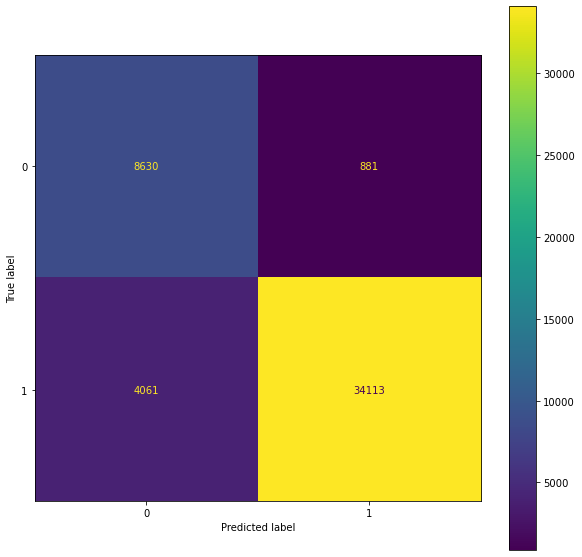

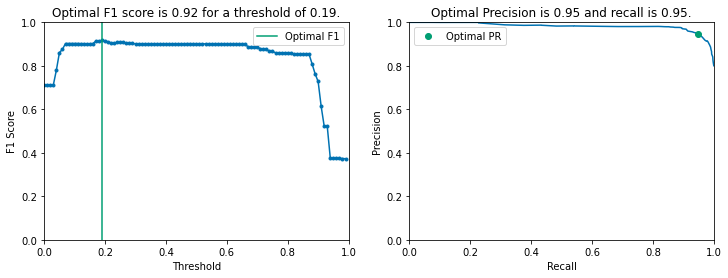

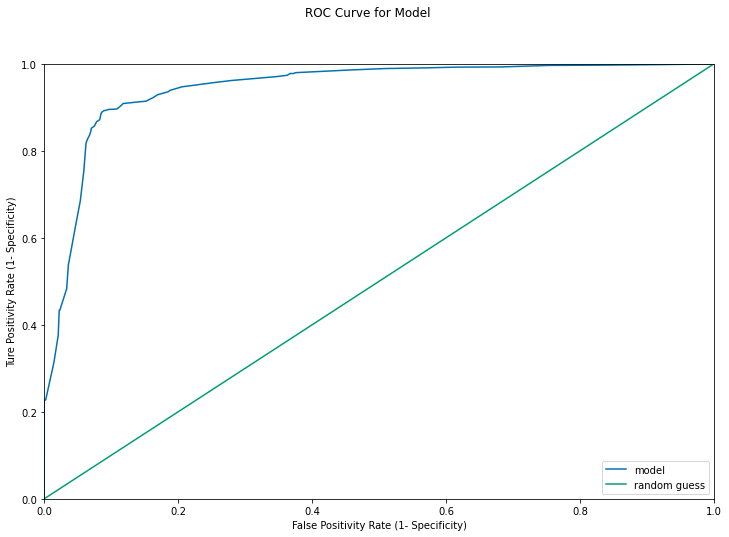

In [107]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_features, X_train[features], y_train_access, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
plot_f1_threshold(X_train[features], y_train_access, model_features)

#roc curve
plot_roc(y_train_access, model_features.predict_proba(X_train[features]))

Plot the classifications geospatially

In [108]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [109]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

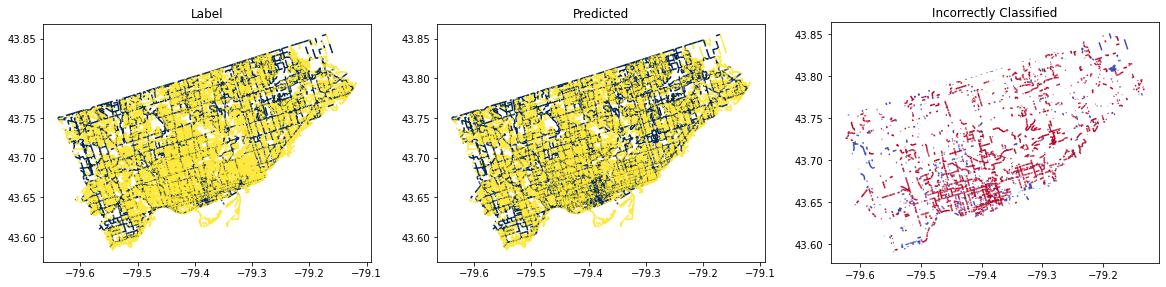

In [110]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['i or c'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')
plotr_diff = plotr[plotr['diff'] != 0]

# Figure
fig, axs = plt.subplots(figsize=(20,12), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
#plotr[plotr['i or c'] == 'incorrect'].plot(ax=axs[2], column='i or c', cmap='coolwarm')
plotr_diff.plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.show()

<br>
Train the random forest classifier and see the results on the test set

In [71]:
model_features_rf = RandomForestClassifier(criterion='entropy', max_features=0.5384874461913766,
                                           max_samples=0.5862816454781242, class_weight='balanced')
model_features_rf.fit(X_train[features], y_train_access)

y_pred = model_features_rf.predict(X_train[features])
#y_prob = model_features.predict_proba(X_train[features])

In [72]:
# Spatial CV
spatial_cv(model_features_rf, grouper=X_train['AREA_ID'], splits=141, X=X_train[features], y=y_train_access)

Mean fold weighted F1 Score: 0.9140462620365275
Mean fold accuracy Score: 0.9063247460115895
Mean fold MSE: 0.09367525398841055


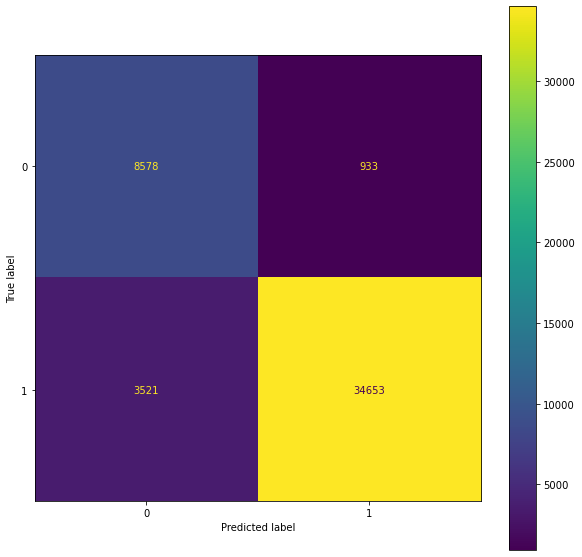

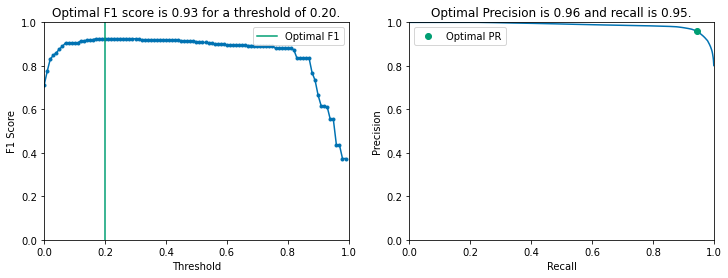

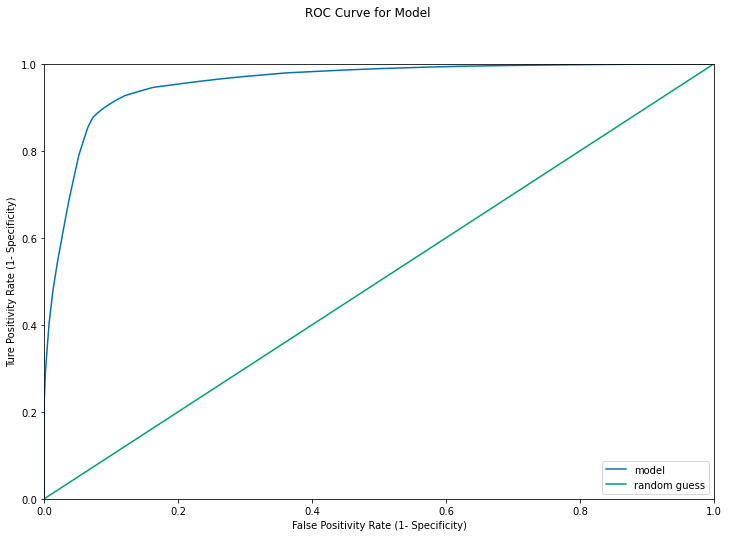

In [73]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_features_rf, X_train[features], y_train_access, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
plot_f1_threshold(X_train[features], y_train_access, model_features_rf)

#roc curve
plot_roc(y_train_access, model_features_rf.predict_proba(X_train[features]))

In [74]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [75]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

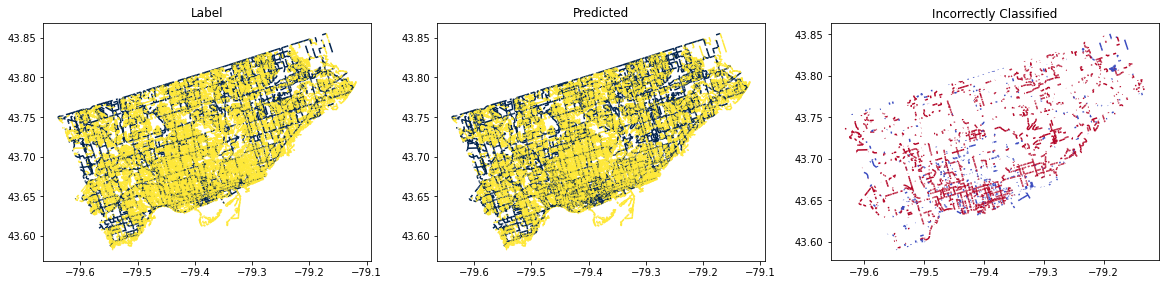

In [76]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['i or c'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')
plotr_diff = plotr[plotr['diff'] != 0]

# Figure
fig, axs = plt.subplots(figsize=(20,12), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
#plotr[plotr['i or c'] == 'incorrect'].plot(ax=axs[2], column='i or c', cmap='coolwarm')
plotr_diff.plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.show()